In [303]:
from typing import List
import re
from math import log
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [304]:
def matching_graph(d: int, probabilities: List[float]) -> nx.Graph:
    """Get the matching graph for the repetition code.
    
    Arguments:
    d - Distance of the code. Should be odd.
    probabilities - A list of bit-flip probablities.
    
    Returns:
    M - The matching graph for this code and error model."""

    assert d >= 3, f"Distance must be >= 3, but got {d}."
    assert d % 2 != 0, f"Distance d must be odd, but got {d}."

    matching_graph = nx.Graph()
    # First add the "extra nodes" for the leftmost and rightmost qubits.
    matching_graph.add_node("r1")
    matching_graph.add_node("r2")
    # Then add the regular syndromes
    for i in range(d - 1):
        matching_graph.add_node(f"s{i}")
    # Add an edge of weight w = log((1-p_i)/p_i) for each qubit.
    for i in range(d):
        w = log((1. - probabilities[i]) / probabilities[i])
        if i == 0:
            matching_graph.add_edge("r1", "s0", weight=w, label="q0")
        elif i == d - 1:
            matching_graph.add_edge("r2", f"s{i-1}", weight=w, label=f"q{i}")
        else:
            matching_graph.add_edge(f"s{i-1}", f"s{i}", weight=w, label=f"q{i}")
    return matching_graph

In [305]:
def error_to_syndrome(err: np.ndarray) -> np.ndarray:
    """Convert a list of bit-flips into a the repetition code syndrome."""

    d = err.size
    check = np.zeros((d-1, d), dtype=bool)
    for i in range(d - 1):
        check[i, i] = True
        check[i, i + 1] = True
    return ((check.astype(int) @ err.astype(int)) % 2).astype(bool)

In [313]:
def syndrome_graph(matching: nx.Graph, syndrome: np.ndarray) -> nx.Graph:
    """Gets the syndrome graph for a binary syndrome vector given the
    matching graph."""

    d = len(matching.nodes()) - 1
    assert syndrome.size == d - 1

    syndrome_nodes: List[str] = []
    # Build a graph with a node for each 1 in the syndrome.
    # The weight between two nodes will be the distance on the matching graph.
    syndrome_gr = nx.Graph()
    for i, b in enumerate(syndrome):
        if b:
            syndrome_gr.add_node(f"s{i}")
    # If there is an odd number of ones in the syndrome,
    # we need to add in one of our "dummy" nodes because there is a flip
    # on the leftmost or rightmost bit.
    if np.sum(syndrome) % 2 != 0:
        if syndrome[0]:
            syndrome_gr.add_node("r1")
        elif syndrome[-1]:
            syndrome_gr.add_node("r2")
        else:
            raise ValueError(f"Syndrome {syndrome} has an odd Hamming weight, but neighter s[0] nor s[-1] is 1.")
    assert set(syndrome_gr.nodes()).issubset(matching.nodes())
    for sn1 in syndrome_gr.nodes():
        for sn2 in syndrome_gr.nodes():
            if sn1 != sn2:
                length = nx.shortest_path_length(matching, sn1, sn2, weight='weight')
                syndrome_gr.add_edge(sn1, sn2, weight=length)
    return syndrome_gr

In [314]:
def repetition_tanner_graph(d: int) -> nx.Graph:
    """Get the Tanner graph for a repetition code."""

    assert d % 2 != 0
    assert d >= 3

    tanner_graph = nx.Graph()
    for i in range(d):
        tanner_graph.add_node(f"q{i}")
        if i == 0:
            tanner_graph.add_node(f"r1")
            tanner_graph.add_node(f"s0")
            tanner_graph.add_edge("q0", "r1")
            tanner_graph.add_edge("q0", "s0")
        elif i == d - 1:
            tanner_graph.add_node("r2")
            tanner_graph.add_edge(f"q{i}", "r2")
            tanner_graph.add_edge(f"q{i}", f"s{i - 1}")
        else:
            tanner_graph.add_node(f"s{i}")
            tanner_graph.add_edge(f"q{i}", f"s{i - 1}")
            tanner_graph.add_edge(f"q{i}", f"s{i}")
    return tanner_graph

In [324]:
def matching_to_correction(matching, matching_gr, tanner_graph) -> np.ndarray:
    """Convert the minimum-weight matching to a binary correction."""

    def qubit_for_syndrome_pair(s1, s2):
        s1_neighbors = set(tanner_graph.neighbors(s1))
        s2_neighbors = set(tanner_graph.neighbors(s2))
        shared_nodes = s1_neighbors & s2_neighbors
        assert len(shared_nodes) == 1, f"{s1_neighbors} {s2_neighbors}"
        q_name = list(shared_nodes)[0]
        idx = int(re.search(r'\d+', q_name).group()) 
        return idx

    # Count qubits in the Tanner graph.
    nq = 0
    for node in tanner_graph.nodes():
        if 'q' in node:
            nq += 1

    correction = [False] * nq
    for n1, n2 in matching:
        # Get a path from n1 to n2 on the matching graph.
        # Each edge on the path will give us a qubit.
        path = nx.shortest_path(matching_gr, n1, n2)
        for i in range(len(path) - 1):
            s1 = path[i]
            s2 = path[i+1]
            idx = qubit_for_syndrome_pair(s1, s2)
            correction[idx] = True
    return np.array(correction)

In [ ]:
d = 5
probs = [0.1] * d
err = np.array([True, False, True, True, False])
syndrome = error_to_syndrome(err)
print(f"syndrome = {syndrome}")

tanner_graph = repetition_tanner_graph(d)
matching_gr = matching_graph(d, probs)
syndrome_gr = syndrome_graph(matching_gr, syndrome)
print(f"syndrome graph nodes: {syndrome_gr.nodes()}")
matching = nx.min_weight_matching(syndrome_gr)
print("matching =", matching)
correction = matching_to_correction(matching, matching_gr, tanner_graph)
print(f"correction = {correction}")
print(correction ^ err)

syndrome = [ True  True False  True]
syndrome graph nodes: ['s0', 's1', 's3', 'r1']
matching = {('s1', 's3'), ('r1', 's0')}
correction = [ True False  True  True False]
[False False False False False]


{'q0': Text(0.4633876653233185, 0.651705379249006, 'q0'),
 'r1': Text(0.3475446017646365, 0.8379980622449582, 'r1'),
 's0': Text(0.5470988372557392, 0.4089945972428498, 's0'),
 'q1': Text(0.5517887109060523, 0.13873517927857695, 'q1'),
 's1': Text(0.4546691302290187, -0.12172865992065204, 's1'),
 'q2': Text(0.25942969246962083, -0.3208347241713696, 'q2'),
 's2': Text(-0.003916891529875419, -0.4146986105397967, 's2'),
 'q3': Text(-0.2847361921649747, -0.4154376240682882, 'q3'),
 's3': Text(-0.5473641739457165, -0.3361766702215359, 's3'),
 'q4': Text(-0.7879013803078201, -0.2422076140826638, 'q4'),
 'r2': Text(-0.9999999999999999, -0.18634931501108415, 'r2')}

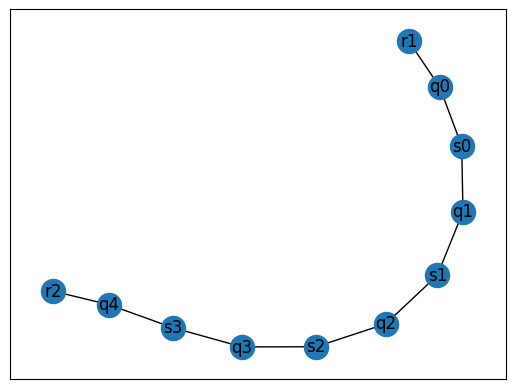

In [327]:
plt.figure()
pos = nx.spring_layout(tanner_graph)
nx.draw_networkx_nodes(tanner_graph, pos)
nx.draw_networkx_edges(tanner_graph, pos)
nx.draw_networkx_labels(tanner_graph, pos)

{'r1': Text(0.9514908811984755, -0.413155509374058, 'r1'),
 'r2': Text(-1.0, 0.2746215170568261, 'r2'),
 's0': Text(0.630618042421567, -0.21099438506115278, 's0'),
 's1': Text(0.2370564352848817, -0.01815578289415748, 's1'),
 's2': Text(-0.19396353454244042, 0.13556377569907002, 's2'),
 's3': Text(-0.6252018243624841, 0.23212038457347192, 's3')}

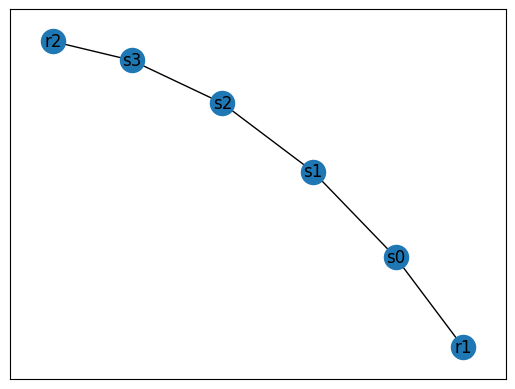

In [328]:
plt.figure()
pos = nx.spring_layout(matching_gr)
nx.draw_networkx_nodes(matching_gr, pos)
nx.draw_networkx_edges(matching_gr, pos)
nx.draw_networkx_labels(matching_gr, pos)

{'s0': Text(1.0, -0.08796709997228733, 's0'),
 's1': Text(-0.21720124196014132, 0.8282530330309154, 's1'),
 's3': Text(0.05985256484060212, -0.5146594376932072, 's3'),
 'r1': Text(-0.842651322880461, -0.22562649536542062, 'r1')}

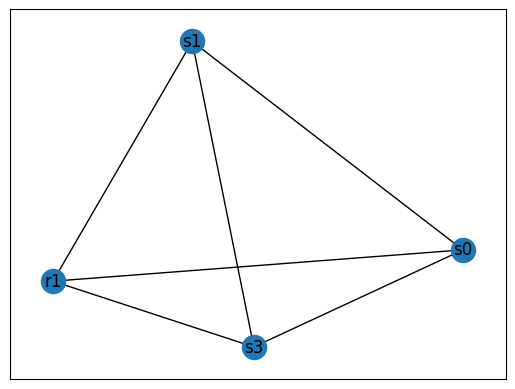

In [329]:
plt.figure()
pos = nx.spring_layout(syndrome_gr)
nx.draw_networkx_nodes(syndrome_gr, pos)
nx.draw_networkx_edges(syndrome_gr, pos)
nx.draw_networkx_labels(syndrome_gr, pos)